# Lab Course Machine Learning
## Exercise Sheet 5
Prof. Dr. Dr. Lars Schmidt-Thieme, Hadi Samer Jomaa
Information Systems and Machine Learning Lab
University of Hildesheim
November 27th, 2017
Submission on December 4th, 2017 at 8:00 am, (on moodle, course code 3113)

#### Datasets
##### 1. Regression Datasets
(a) Wine Quality: (use winequality-red.csv)http://archive.ics.uci.edu/ml/datasets/Wine+Quality

##### 2. Classification Datasets
(a) Bank Marketing: (use bank.csv) https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

#### You are required to pre-process given datasets.
1. convert any non-numeric values to numeric values. For example you can replace a country name with an integer value or more appropriately use hot-one encoding. [Hint: use hashmap (dict) or pandas.get_dummies].
2. If required drop out the rows with missing values or NA. In next lectures we will handle sparse data, which will allow us to use records with missing values.
3. Normalize our data


In [1]:
import numpy as np
import pandas as pd
import itertools as it
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


RWN = pd.read_table("/home/salvatore/Documents/Data Analytics/LAB Machine Learning/Excercise 5/winequality-red.csv",sep=";") #Data do not have string values 
                                                                             #no need to preprocess
BNK = pd.read_table("/home/salvatore/Documents/Data Analytics/LAB Machine Learning/Excercise 5/bank-additional.csv",sep=";") #Data need pre-process
BNK.drop(['duration','default','day_of_week','contact'], axis=1, inplace=True) #Droping this column as suggested by the datasite
BNK.replace({"pdays":{999:0}},inplace=True) #Changing the value of 999 to 0 in "pdays"
BNK.replace({"y":{"no":0,"yes":1}},inplace=True) #Changing the No for "0" and Yes for "1"

def Normalize(Matrix): #For normalize an array of data
    Matrix = (Matrix - np.average(Matrix,axis=0))/np.std(Matrix,axis=0)
    return Matrix

def split(Dataframe): #Assume that the last column always will contain the "Y values and that values in "Y" are NOT strings
    Y = np.array([Dataframe.iloc[:,-1]]).T                        #Converting the Y column into array
    Dataframe = Dataframe.drop(Dataframe.columns[[-1,]], axis=1)  #Getting dummies and converting X into array
    X = Normalize(np.array(pd.get_dummies(Dataframe)))            #Normalizing data  
    Matrix = np.concatenate((X,Y),axis =1)                        #We get X and Y together again to do the split
    msk = np.random.rand(len(Matrix)) < 0.8                       #Random assign
    tr = Matrix[msk]
    tst = Matrix[~msk]    
    Ytr = np.array([tr[:,-1]]).T
    Xtr= tr[:,0:-1]
    Ytst = np.array([tst[:,-1]]).T
    Xtst= tst[:,0:-1]
    return Xtr, Ytr, Xtst, Ytst                                   #Tr is for training, Tst is for testing

## Exercise 1: Regularization (8 Points)
You have to implement Ridge Regression using mini-Batch Gradient Descent (mini-BGD) algorithm. Now
your SGD algorithm will have three hyperparameters i.e. 1) learning rate (stepsize) α, 2) regularization
constant λ and 3) number of mini Batches batchsize.
1. Implement Ridge Regression using mini-BGD algorithm
2. you can use any algorithm for selecting learning rate i.e. (AdaGrad, BoldDriver or fixed stepsize)
3. Pick three values of α0 and λ, these values should be picked from relatively small to large. You should keep a fixed batchsize = 50.
4. Train you model for each combination of the picked values of α and λ, and for each training epoch (an epoch is equal to going over all mini-batches once) record RMSE on training and test data.
5. For each combination of α0 and λ, plot RM SE train and RM SEtest per iteration. [Hint: you can
plot RM SEtrain on positive axis and RM SE test on negative axis of same plot].



In [3]:
def minibatch(x,y,i):                                #i= number of items per batch
    Index = np.arange(len(x))                        #Create a list of the indices of the matrix
    Random = np.random.choice(Index,i,replace=False) #Select 50 random indexes
    return x[Random,:], y[Random,:]                  #Show those 50 random indexes from the original matrix

def Lglklh(B,x,y): #Calculates the likelihood for a given vector X and B, comparing vs true values Y
    p = 1/(1+np.exp(-1*x.dot(B)))
    Liklh = np.sum(y*np.log(p) + (1-y)*np.log(1 - p))/len(x)
    return Liklh

def SQLoss(x,y,B):                    #Root Mean Squared Loss (y-ŷ)²
    Loss = (np.sum((y - x.dot(B))**2)/len(x))**0.5
    return Loss

""" 
This implementation requires the following parameters:
1) x, y are the training data sets
2) x2 and y2 are the test data sets to be compared agains the training data sets
3) The hyper parameters are Step size(mu), the ridge constant (rd)
4) Batch size and the number of batchs per epoch are both fixed at 50
5) The final input is 0 = Linear Regression and 1 = Logistic Regression
"""
def RidgeLinReg(x,y,x2,y2,mu,λ,epoch,MinibatchSize,BatchPerEpoch,LinOrLog):      # mu step length, rd ridge value
    ErrTr = []                      #To store the error on trial data
    ErrTst = []                     #To store the error on test data
    Btr = np.array([[1]]*len(x.T))  #Betas values Initialized to 1
    for n in np.arange(epoch):      #Defining the number of times to run an epoch
        for i in np.arange(BatchPerEpoch):      #Times a minibatch is created within an epoch
            if LinOrLog == 0:
                xt, yt = minibatch(x,y,MinibatchSize)
                Gd = xt.T.dot(yt -xt.dot(Btr))  #Gradient
                Btr = (1-2*λ*mu)*Btr + mu*Gd    #Calculates the new value of Betas
            else:
                if LinOrLog == 1:           #y must be 0's and 1's
                    xt, yt = minibatch(x,y,MinibatchSize)
                    p = 1/(1+np.exp(-1*xt.dot(Btr)))
                    Gd = xt.T.dot(yt-p)
                    Btr = (1-2*λ*mu)*Btr + mu*Gd    #Calculates the new value of Betas
                else:
                    print("Error, arguments must be 0 or 1")
                    break
        if LinOrLog == 0:
            ErTr = SQLoss(x,y,Btr)
            ErTst = SQLoss(x2,y2,Btr)
        if LinOrLog == 1:           
            ErTr = Lglklh(Btr,x,y) 
            ErTst = Lglklh(Btr,x2,y2)                
        ErrTr.append(ErTr)
        ErrTst.append(ErTst)
    plt.plot(ErrTr,'-b')
    plt.plot(ErrTst,'-r')
    plt.title("RMSE vs Epochs")
    plt.xlabel("Epochs")    
    plt.ylabel("RMSE")
    plt.legend(["Training","Test"])
    plt.show()
    print("Final Error Trial",ErrTr[-1])    #Only used to print the last value of the Error on trial
    print("Final Error Test",ErrTst[-1])    #Only used to print the last value of the Error on test
    return ErrTr, ErrTst #If not stored, at the end will appear the complete list of both values

## Data from Red Wines - Ridge Linear Regression
#### Data Brief: 
The dataset is related to red wine of the Portuguese "Vinho Verde" wine. For more details, consult: http://www.vinhoverde.pt/en/ or the reference [Cortez et al., 2009]. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

#### Programming goal: 
In this step, 4 variables are generated on X and Y for training and testing using for each regression, a different learing rate and ridge constant.

For each combination, a plot is delivered containing a comparison of the error from the Trial dataset vs the error of test dataset at the end of each epoch.

The values to be tested are:

    1) Mu = 1e-5   Ridge Cte= 1
    2) Mu = 1e-4   Ridge Cte= 10
    3) Mu = 1e-3   Ridge Cte= 20

A final plot with the 6 errors measured is also presented

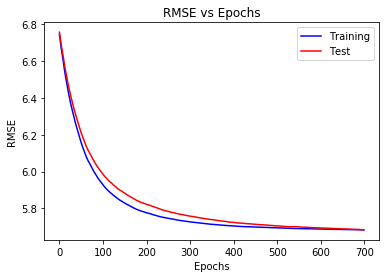

Final Error Trial 5.68349158319
Final Error Test 5.68282277595


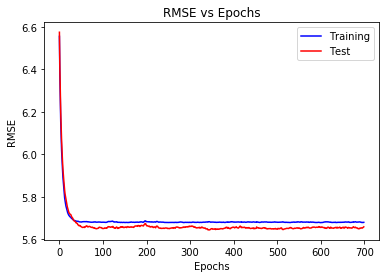

Final Error Trial 5.68045713309
Final Error Test 5.65918014476


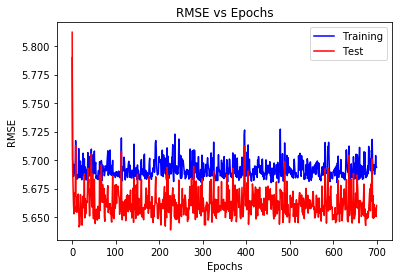

Final Error Trial 5.69367486933
Final Error Test 5.66024178748


In [4]:
Wxtr, Wytr, Wxtst, Wytst = split(RWN) #Splitting the data from Wines

#Ridge
WEr1, WEs1 =RidgeLinReg(Wxtr,Wytr,Wxtst,Wytst,1e-5,1,700,50,10,0)
WEr2, WEs2 =RidgeLinReg(Wxtr,Wytr,Wxtst,Wytst,1e-4,10,700,50,10,0)
WEr3, WEs3 =RidgeLinReg(Wxtr,Wytr,Wxtst,Wytst,1e-3,20,700,50,10,0)

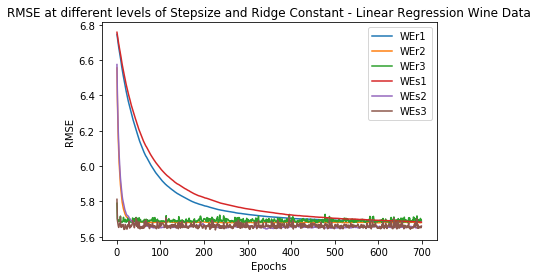

In [5]:
"Ploting the previous graphs together"
"WEr = Wine Error from Trial Data"
"WEs = Wine Error from Test Data"
plt.plot(WEr1)
plt.plot(WEr2)
plt.plot(WEr3)
plt.plot(WEs1)
plt.plot(WEs2)
plt.plot(WEs3)
plt.title("RMSE at different levels of Stepsize and Ridge Constant - Linear Regression Wine Data")
plt.xlabel("Epochs")    
plt.ylabel("RMSE")
plt.legend(["WEr1","WEr2","WEr3","WEs1","WEs2","WEs3",])
plt.show()

### Discussion:
For all the values of step size and ridge constant presented, the error converges to a similar level using trial/test data sets. 
Higher learning rates leads to a faster convergence although it presents a noisy behaviour inherentto the random nature of this procedure; such behaviour is smothered by smaller step sizes

For this data split, is observed that the error from the test is always lower than the obtained in the trial data. That is a sign of good model fitness and an optimum an optimum split. Neverthless, it must be mentioned that it is the result of several previous attempts on different splits being the results of this one, the best.

Regarding the ridge regularization, is observed to deliver a more constant value of B trough the algorithm, resulting in a less noisy plot
##### Bellow are the plot of a different ridge constant (10, 50 ,300) at constant learing rate, in order to evaluate their influence on the model fit.

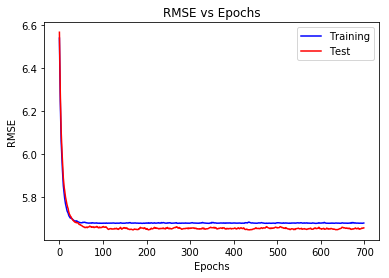

Final Error Trial 5.6809738567
Final Error Test 5.65834879003


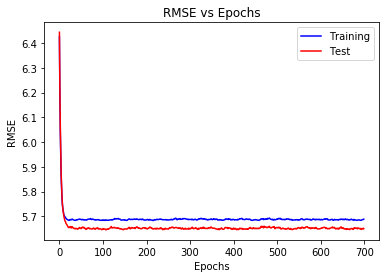

Final Error Trial 5.68898018805
Final Error Test 5.65062315927


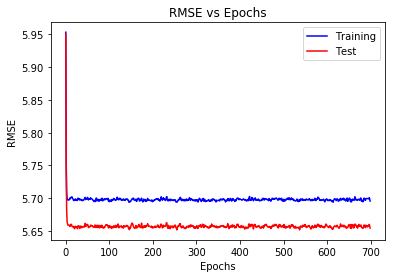

Final Error Trial 5.69565525077
Final Error Test 5.65445668275


([5.9532939132541509,
  5.7536027144289319,
  5.7088165676273146,
  5.6985642110555572,
  5.6983024697515159,
  5.6971480941050983,
  5.6972909209371769,
  5.6973466053709743,
  5.6984979236280369,
  5.6979705519794734,
  5.7008205472343967,
  5.7002278738961634,
  5.7011839804750757,
  5.7013817196028294,
  5.7022070049376161,
  5.6999449840492673,
  5.6996331084369558,
  5.6981071565058032,
  5.6964894186168848,
  5.6966153168718039,
  5.6972021884814996,
  5.6968843712824651,
  5.6990258539191787,
  5.6970729879558144,
  5.6977836707214067,
  5.6979161553269027,
  5.6964032650312157,
  5.6973501877233153,
  5.7001656733909698,
  5.6997293880658253,
  5.6980563677264993,
  5.6990149655486482,
  5.6972171168150476,
  5.6976760480900586,
  5.6985089600832124,
  5.6979443582621485,
  5.6967101931911692,
  5.6970119735741518,
  5.6963015747193566,
  5.697114790821753,
  5.696847684703827,
  5.6969819455148709,
  5.6982810241815285,
  5.6991502618047143,
  5.7011845045206009,
  5.70102720

In [7]:
RidgeLinReg(Wxtr,Wytr,Wxtst,Wytst,1e-4,10,700,50,10,0)
RidgeLinReg(Wxtr,Wytr,Wxtst,Wytst,1e-4,50,700,50,10,0)
RidgeLinReg(Wxtr,Wytr,Wxtst,Wytst,1e-4,300,700,50,10,0)

### Conclusion: 
For linear regression, the learning rate step is observed to be crucial in order to find a faster convergence and a more stable residuals value where in the other hand, the effect of the Ridge constant is not well observed due it is more suited for polynomial fits.

## Data from Bank Marketing - Ridge Logistic Regression
#### Data Brief:
The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y) Yes= 1, No = 0

#### Programming goal:
In this step, 4 variables are generated on X and Y for training and testing using for each regression, a different learing rate and ridge constant.
For each combination, a plot is delivered conaiining a comparison of the error from the Trial dataset vs the error of test dataset at the finish of each epoch.

The values to be tested are:

    1) Mu = 1e-2   Ridge Cte= 10
    2) Mu = 1e-3   Ridge Cte= 5
    3) Mu = 1e-4   Ridge Cte= 1

A final plot with the 6 errors measured is also presented

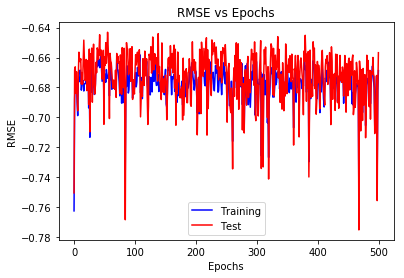

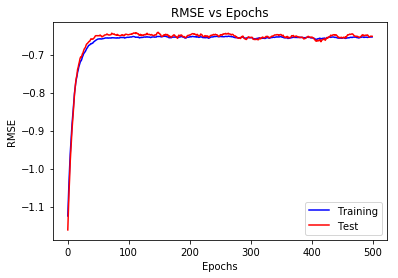

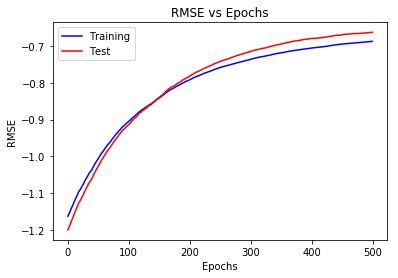

In [155]:
Bxtr, Bytr, Bxtst, Bytst = split(BNK) #Splitting the data from Banks

#Ridge Regularization on Bank Data
ETr1, ETst1 =RidgeLinReg(Bxtr,Bytr,Bxtst,Bytst,1e-2,10,500,50,2,1)
ETr2, ETst2 =RidgeLinReg(Bxtr,Bytr,Bxtst,Bytst,1e-3,5,500,50,2,1)
ETr3, ETst3 =RidgeLinReg(Bxtr,Bytr,Bxtst,Bytst,1e-4,1,500,50,2,1)


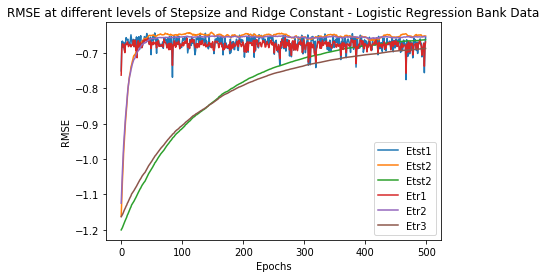

In [156]:
plt.plot(ETst1)
plt.plot(ETst2)
plt.plot(ETst3)
plt.plot(ETr1)
plt.plot(ETr2)
plt.plot(ETr3)
plt.title("RMSE at different levels of Stepsize and Ridge Constant - Logistic Regression Bank Data")
plt.xlabel("Epochs")    
plt.ylabel("RMSE")
plt.legend(["Etst1","Etst2","Etst2","Etr1","Etr2","Etr3",])
plt.show()

### Discussion:
For all the values of step size and ridge constant presented, the error converges to a similar level using trial/test data sets. 
Higher learning rates leads to a faster convergence although it presents a noisy behaviour inherentto the random nature of this procedure; such behaviour is smothered by smaller step sizes

For this data split, is observed that the error from the test is always lower than the obtained in the trial data. That is a sign of good model fitness and an optimum an optimum split. Neverthless, it must be mentioned that it is the result of several previous attempts on different splits being the results of this one, the best.

## Exercise 2: Hyper-parameter tuning and Cross validation (12 Points) 
In this section you will implement grid search with k-fold cross-validation for model selection i.e. choosing best hyperparameters. You will use your implementation from Exercise 1: Ridge Regression using mini- Batch Gradient Descent (mini-BGD) algorithm.

1) Pick a range of α0 and λ defined on grid. You can choose fixed batchsize=50.

2) Implement k-fold cross-validation protocol for grid search. For each combination of α0 and λ you will perform k-fold cross-validation. let k = 5 in this case.

3) Keep track of mean performance (i.e. RMSE value) across k-folds for each set of hyperparameters. Plot on the grid α0 vs λ the RMSE score for all combinations. [Hint: you can use a 3D plot with axes={α0 , λ, RMSE}]

4) Finally, for the optimal value of α0 and λ, train your model on complete training data and evaluate on test data.

5) Plot RM SE train and RM SE test per iteration. [Hint: you can plot RM SE train on positive axis and RM SE test on negative axis of same plot]. Compare your result with results in previous plots. [Hint: If you were unable to complete Exercise 1, you can still complete Exercise 2 by using linear regression implementation from Exercise Sheet 3 and adding regularization term. There will be some penalty for
this.]


In [21]:
def RidgeLRFold(x,y,mu,λ,epoch,MinibatchSize,BatchPerEpoch,fold,LinOrLog):      # mu step length, rd ridge value 
    ErrTr = []                                  #To store the error on trial data
    Bresults = []                               #To store tue values of Betas per fold
    for k in np.arange(fold):
        Btr = np.array([[0]]*len(x.T))          #Betas values Initialized in each fold
        w=np.round(len(x)//fold)                #Number of items to show on x & y data, per fold
        xf = x[(k*w):((k+1)*w):]                #Show the items according to its index
        yf = y[(k*w):((k+1)*w):]
        for n in np.arange(epoch):              #Number of times to run an epoch
            for i in np.arange(BatchPerEpoch):  #Times a minibatch is created within an epoch
                if LinOrLog == 0:
                    xt, yt = minibatch(xf,yf,MinibatchSize)
                    Gd = xt.T.dot(yt -xt.dot(Btr))  #Gradient
                    Bn = (1-2*λ*mu)*Btr + mu*Gd    #Calculates the new value of Betas
                    Btr = Bn
                else:
                    if LinOrLog == 1:           #y must be 0's and 1's
                        xt, yt = minibatch(xf,yf,MinibatchSize)
                        p = 1/(1+np.exp(-1*xt.dot(Btr)))
                        Gd = xt.T.dot(yt-p)
                        Bn = (1-2*λ*mu)*Btr + mu*Gd    #Calculates the new value of Betas
                        Btr = Bn
                    else:
                        print("Error, arguments are 0 or 1")
                        break
            if LinOrLog == 0:
                ErTr = SQLoss(xf,yf,Bn)
            if LinOrLog == 1:           
                ErTr = Lglklh(Bn,xf,yf) 
            ErrTr.append(ErTr)
            Bresults.append(Bn)
    #plt.plot(ErrTr)                         #Actived when required to plot the RMSE for each K-fold
    #plt.title("RMSE vs Epochs")
    #plt.xlabel("Epochs")    
    #plt.ylabel("RMSE")
    #plt.legend(["Training","Test"])
    #plt.show() 
    Bfinal = np.average(Bresults, axis=0)
    return Bfinal

### Example
The idea behind K-fold cross validation is that the data must be splitted in K-subsets (in this case, 5) and for each, a set of betas must be learned; the final value of Betas corresponds to an average value of all the betas learned for the K-subsets

Bellow it a plot of RMSE vs epoch, for each K-data fold; the error converges to its minumum, leading K-different horizontal lines

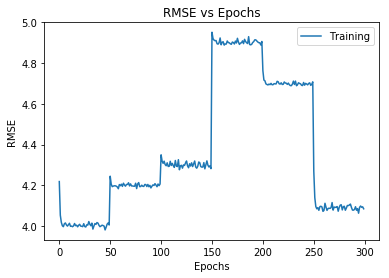

array([[-0.24658905],
       [-0.11956858],
       [-0.13995735],
       [-0.06419237],
       [-0.06138969],
       [-0.02754626],
       [ 0.05794847],
       [-0.03456617],
       [ 0.16896282],
       [ 0.04233379],
       [-0.15800656]])

In [12]:
RidgeLRFold(Wxtr,Wytr,5e-4,10,50,50,50,6,0)

## Grid values (Wine Data Set -Linear Regression)
 
 Bellow is the plot of the grid values for step size and Ridge constant. The minibachsize is held at 50 per fold.
 
 The values to be tested are:
 
 Step size = 1e-3, 1e-4, 1e-5
 
 Ridge Reg. Value = 1, 5, 10

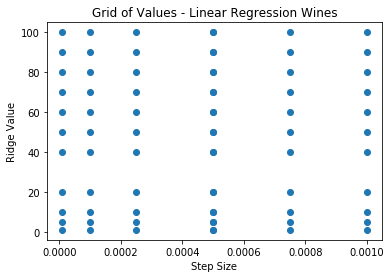

In [33]:
Step = [1e-3, 5e-4,1e-4,5e-4,1e-5, 7.5e-4,2.5e-4]      #List of values of stepsize
Ridge = [1,5,10,20,40,50,60,70,80,90,100]               #List of values of Ridge regularization
Comb = np.array(list(it.product(Step,Ridge))) #Posible combiations on Step Size-Ridge Regularization

plt.title("Grid of Values - Linear Regression Wines")
plt.xlabel("Step Size")    
plt.ylabel("Ridge Value")
plt.plot(Comb[:,0], Comb[:,1], 'o')
plt.show()

In [18]:
""" 
This algorithm is created to obtain all the errors at once of all the posible combinations of the hyperparameters Mu, λ,
defined in the Grid. 
The function defined for K-fold delivers the set of B's averaged after K-regresions within the trial data.
In this algorithm, using that B-averaged value, the Error is measured again vs the complete train data (withouth K-fold)
and using a combination of (α, λ) of the Grid. The Error value is then stored in a list.
The resulting algorithm shows a scatter plot of RMSE/LogLoss on z-axis vs (α, λ)
"""

def RMSEGrid(x,y,GridList,epoch,MinibatchSize,BatchPerEpoch,fold,LinOrLog):
    RMSEGrid = []
    BetasLearned = []
    for i in np.arange(len(GridList)):
        Mu, λ = GridList[i]
        print("α: ",Mu,"λ: ",λ)
        Bfinal = RidgeLRFold(x,y,Mu,λ,epoch,MinibatchSize,BatchPerEpoch,fold,LinOrLog)
        if LinOrLog == 0:

        if LinOrLog == 1:
            ErTr = Lglklh(Bfinal,x,y) 
        RMSEGrid.append(ErTr)
        BetasLearned.append(Bfinal)
        print("Error is",ErTr)
    fig = plt.figure()
    ax= fig.add_subplot(111,projection='3d')
    xs = GridList[:,0]
    ys = GridList[:,1]
    zs = np.array(RMSEGrid)
    ax.scatter(xs,ys,zs,marker='^')
    ax.set_xlabel("Step Size")
    ax.set_ylabel("λ")
    ax.set_zlabel("Error: ")
    plt.show()
    return BetasLearned, RMSEGrid

α:  0.001 λ:  1.0
Error is 5.755194423
α:  0.001 λ:  5.0
Error is 5.73719749249
α:  0.001 λ:  10.0
Error is 5.72552348679
α:  0.001 λ:  20.0
Error is 5.71382970305
α:  0.001 λ:  40.0
Error is 5.70446829636
α:  0.001 λ:  50.0
Error is 5.70176233201
α:  0.001 λ:  60.0
Error is 5.70040296436
α:  0.001 λ:  70.0
Error is 5.69989210248
α:  0.001 λ:  80.0
Error is 5.69894063397
α:  0.001 λ:  90.0
Error is 5.69894769419
α:  0.001 λ:  100.0
Error is 5.69762451159
α:  0.0005 λ:  1.0
Error is 5.75462998749
α:  0.0005 λ:  5.0
Error is 5.73544829331
α:  0.0005 λ:  10.0
Error is 5.72510721762
α:  0.0005 λ:  20.0
Error is 5.71304814209
α:  0.0005 λ:  40.0
Error is 5.70398030583
α:  0.0005 λ:  50.0
Error is 5.70114790749
α:  0.0005 λ:  60.0
Error is 5.69967668035
α:  0.0005 λ:  70.0
Error is 5.69940536492
α:  0.0005 λ:  80.0
Error is 5.69854462376
α:  0.0005 λ:  90.0
Error is 5.69866110736
α:  0.0005 λ:  100.0
Error is 5.69782547176
α:  0.0001 λ:  1.0
Error is 5.74527872781
α:  0.0001 λ:  5.0
Error is

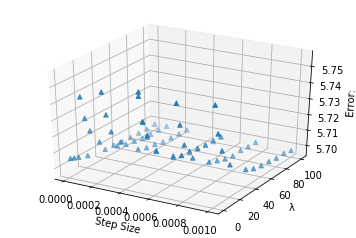

In [34]:
Betas, RMSE_Grid = RMSEGrid(Wxtr,Wytr,Comb,50,50,50,5,0)

### Discussion:
The minor error was obtained with a small step size, and a high ridge constant (although, the difference between errors across the values of the Ridge regularization at this step size is very small)

    Combination choosen: a) Step size= 1e-5   b)λ = 10


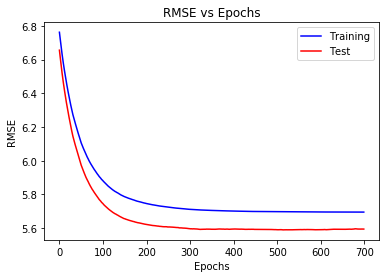

Final Error Trial 5.69517655152
Final Error Test 5.59442208405


In [408]:
ErKfTr, ErKfTst =RidgeLinReg(Wxtr,Wytr,Wxtst,Wytst,1e-5,10,700,50,10,0)

In [412]:
#This are the final errors of the Trial and Test data sets from the first part
#For this case the Step size was 1e-5 and λ = 1
print(WEr1[-1])
print(WEs2[-1])

5.69828153832
5.60199538194


## Conclusion:
#### The error values obtained after Hyperparameter optimization using k-fold cross validation, are slightly better than the error values delivered by choosen the hyperparameters at random.

## Grid values (Bank Data Set -Logistic Regression)
 Minibatchsize:50
 
The values to be tested are:

    1) Mu = 1e-2   Ridge Cte= 10
    2) Mu = 5e-3   Ridge Cte= 5
    3) Mu = 1e-4   Ridge Cte= 1

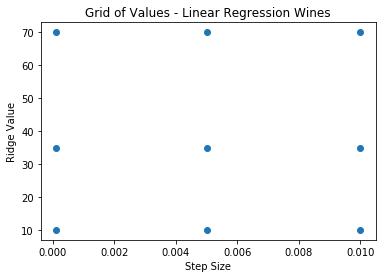

In [429]:
StepL = np.arange[1e-2, 5e-3, 1e-4,]
RidgeL = [10,35,70]
CombL = np.array(list(it.product(StepL,RidgeL))) #Posible combinations on Step Size-Ridge Regularization

plt.title("Grid of Values - Linear Regression Wines")
plt.xlabel("Step Size")    
plt.ylabel("Ridge Value")
plt.plot(CombL[:,0], CombL[:,1], 'o')
plt.show()

α:  0.01 λ:  10.0
Error is -0.658166850052
α:  0.01 λ:  35.0
Error is -0.672037358993
α:  0.01 λ:  70.0
Error is -0.675677513387
α:  0.005 λ:  10.0
Error is -0.658188563617
α:  0.005 λ:  35.0
Error is -0.672125598237
α:  0.005 λ:  70.0
Error is -0.678736652124
α:  0.0001 λ:  10.0
Error is -0.660320618266
α:  0.0001 λ:  35.0
Error is -0.672323339749
α:  0.0001 λ:  70.0
Error is -0.678970911115


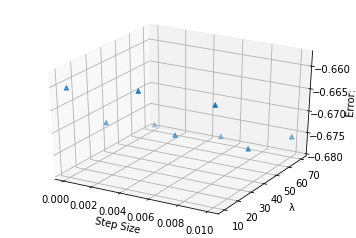

In [433]:
Wxtr, Wytr, Wxtst, Wytst = split(RWN) #Splitting the data from Wines
Betas, RMSE_Grid = RMSEGrid(Bxtr,Bytr,CombL,50,50,50,5,1)

### Discussion:
The minor error was obtained with a big step size, and a low ridge constant (although, the difference between errors across the values of the Ridge regularization at this step size is very small)

    Combination choosen: a) Step size= 0.01   b)λ = 10


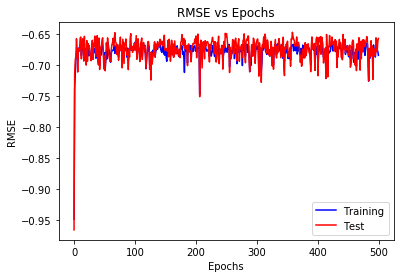

Final Error Trial -0.684049383616
Final Error Test -0.656827110091


In [456]:
BKfETr1, BKfETst1 =RidgeLinReg(Bxtr,Bytr,Bxtst,Bytst,0.01,10,500,50,2,1)

## Conclusion:
#### The error values obtained after Hyperparameter optimization using k-fold cross validation, are slightly better than the error values delivered by choosen the hyperparameters at random.

## Bonus: Implement Newton’s Method (5 Points)
This is a bonus exercise. In this exercise you are required to implement Newton’s method to solve logistic regression with regularization. The algorithm is given at https://www.ismll.uni-hildesheim.de/lehre/ml-16w/script/ml-03-A2-linear-classification.pdf.
1. Pick three values of α and λ, these values should be picked from relatively large to small. You can choose fixed batchsize=50.
2. Split your data into train and test
3. Implement Newton’s method [Hint: use scipy or numpy for inverting a matrix or other matrix oper- ations, do not use scipy.optimize.newton)
4. Train you model for each combination of the picked values of α and λ, and for each iteration (one iteration is equal to updating all model parameters once) record RMSE on training and test data. train test train5. Plot RM SE and RM SE per iteration. [Hint: you can plot RM SE on positive axis and RM SE test on negative axis of same plot].


In [645]:
def LogRegGD (x,y,i,mu,λ): #Using Newton's method
    n = 0
    Btr = np.array([[0]]*len(x.T)) #Initialized to 0
    Lss = []
    while n<i:
        n = n+1
        S = np.diag([0.25]*len(x))
        p = 1/(1+np.exp(-1*x.dot(Btr)))
        g = x.T.dot(p-y)
        H = x.T.dot(S.dot(x))  
        Bn = np.linalg.solve(H,-g)   #Is the same, as geting the inverse matrix
        Val= (Lglklh(Btr,x,y) - Lglklh(Btr + mu*Bn,x,y))
        if Val <=0:
            mu= mu*0.1
        else:
                mu = mu*1.1
        Btr = (1-2*λ*mu)*Btr +mu*Bn
        Lss.append(Lglklh(Btr,x,y))
    else:
        plt.plot(Lss)
        plt.title("LossLog vs Iteration")
        plt.xlabel("Iterations")
        plt.ylabel("LossLog")
        plt.show()

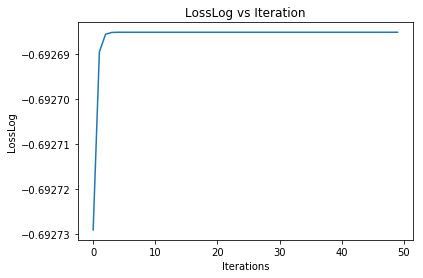

In [646]:
LogRegGD(Bxtr,Bytr,50,0.05,5)

The Loglikelihoood converges